# 1. Introduction to ASOP Dreaming Language Model
Welcome to the ASOP Dreaming Language Model! This code creates a recurrent neural network (RNN) that generates dreamy and illusional Actuarial Standards of Practice. 

This code is for fun and educational purposes only. If an alien had access to the ASOP documents and learned from them, it must have produced something similar to this model!

The network predicts the next character in a sequence by analyzing the previous 40 characters as input. Think of it like carrying on a conversation where you guess the next word based on the previous 40 words.

It is trained on a small dataset of 800,000 characters (about 1MB) extracted from "Actuarial Standards of Practice" (ASOP) by the Actuarial Standards Board. The data was divided into "windows" of 41 characters for training: 40 for input and 1 for the desired output (the next character).

Although a relatively small neural network, it contains around 3 million parameters. It took about 5 hours to train on an Apple M2 Pro chip going through 21 epochs.

A large portion of the code was referenced from an exercise in DeepLearning AI's Sequence Models online course: https://www.coursera.org/learn/nlp-sequence-models/.  
This project was inspired by the work of renowned practitioner and researcher Andrej Karpathy. You can find his code implementation here: https://gist.github.com/karpathy/d4dee566867f8291f086 and read more about "The Unreasonable Effectiveness of Recurrent Neural Networks" in his blog post: https://karpathy.github.io/2015/05/21/rnn-effectiveness/.

# 2. Load Packages and Modules
This section imports various packages and modules that are required for the subsequent code.  
The packages include `keras`, `numpy`, `random`, `sys`, and `io`.  
These packages provide functionalities for handling neural networks, array manipulation, random number generation, system-specific operations, and input/output operations respectively.

In [1]:
# Load Packages
from __future__ import print_function

# Import the required Keras modules
from tensorflow.keras.callbacks import LambdaCallback, TensorBoard
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, Masking
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Import numpy for array manipulation
import numpy as np

# Import random for generating random numbers
import random

# Import sys for system-specific parameters and functions
import sys

# Import io for input/output operations
import io

# 3. Input
## 3.1 Define Functions and Input Variables

In [2]:
def build_data(text, Tx = 40, stride = 3):
    """
    Create a training set by scanning a window of size Tx over the text corpus, with stride 3
    
    Arguments:
    text -- string, corpus of text
    Tx -- sequence length, number of time-steps (or characters) in one training example
    stride -- how much the window shifts itself while scanning
    
    Returns:
    X -- list of training examples
    Y -- list of training labels
    """
    
    X = []
    Y = []

    for i in range(0, len(text) - Tx, stride):
        X.append(text[i: i + Tx])
        Y.append(text[i + Tx])
    
    print('Number of training examples:', len(X))
    
    return X, Y

In [3]:
def vectorization(X, Y, n_x, char_indices, Tx = 40):
    """
    Convert X and Y (lists) into arrays to be given to a recurrent neural network
    
    Arguments:
    X -- input characters
    Y -- output character
    Tx -- integer, sequence length
    
    Returns:
    x -- array of shape (m, Tx, len(chars))
    y -- array of shape (m, len(chars))
    """
    
    m = len(X)
    x = np.zeros((m, Tx, n_x), dtype=bool) # x = np.zeros((m, Tx, n_x), dtype=np.bool) 
    y = np.zeros((m, n_x), dtype=bool)     # y = np.zeros((m, n_x), dtype=np.bool)
    
    for i, sentence in enumerate(X):
        for t, char in enumerate(sentence):
            x[i, t, char_indices[char]] = 1
        y[i, char_indices[Y[i]]] = 1
        
    return x, y 

In [4]:
# Set the length of the sequences for training
Tx = 40

## 3.2 Input data processing

The text file was prepared using the Actuarial Standards Board's Actuarial Standards of Practice documents.  
The PDF library of ASOPs was downloaded as of December 2023 from the following link:  
http://www.actuarialstandardsboard.org/wp-content/uploads/2023/12/ASOPs-as-of-Decemeber-2023.zip

In [5]:
print("Loading text data...")

# Read the text file and store its contents in the variable 'text'
# The text source file has been converted from multiple pdfs to one text file
text = io.open('../data/combined_text_life.txt', encoding='utf-8').read().lower()

# Print the length of the text (number of characters)
print('Corpus length:', len(text))

Loading text data...
Corpus length: 806201


In [6]:
# Create a list of unique characters in the 'text' variable and sort them
chars = sorted(list(set(text)))

# Create a dictionary that maps each character to its index in the 'chars' list
char_indices = dict((c, i) for i, c in enumerate(chars))

# Create a dictionary that maps each index to its corresponding character in the 'chars' list
indices_char = dict((i, c) for i, c in enumerate(chars))

# Print unique characters in the corpus and the number of them
print('Unique characters in the corpus:', chars)
print('Number of unique characters:', len(chars), ' \n')

# Print a message indicating the creation of the training set
print("Creating training set...")

# Build the training data by dividing the 'text' into sequences of length Tx with a stride of 3
X, Y = build_data(text, Tx, stride=3)

# Print a message indicating the vectorization of the training set
print(" \nVectorizing training set...")

# Convert the training data into numerical vectors using one-hot encoding
x, y = vectorization(X, Y, n_x=len(chars), char_indices=char_indices) 

print("Data processing done")

Unique characters in the corpus: ['\n', ' ', '#', '$', '%', '&', "'", '(', ')', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\xa0', 'ω', '‐', '–', '—', '‘', '’', '“', '”', '•', '…', '⎯', '\uf0b7', '\uf0be', '\uf8e7']
Number of unique characters: 69  

Creating training set...
Number of training examples: 268721
 
Vectorizing training set...
Data processing done


In [7]:
# Review two examples of X and Y datasets starting from index 1000
print("First 2 elements of X:", X[1000:1002])
print("First 2 elements of Y:", Y[1000:1002])

First 2 elements of X: ['uarial opinion based on asset adequacy a', 'ial opinion based on asset adequacy anal']
First 2 elements of Y: ['n', 'y']


# 4. Model
The model structure is based on what Karpathy noted in his blog as follows:  
*... we get approximately 1MB text file, or about 1 million characters (this is considered a very small dataset by the way).
Technical: Lets train a 2-layer LSTM with 512 hidden nodes (approx. 3.5 million parameters), and with dropout of 0.5 after each layer.
We’ll train with batches of 100 examples and truncated backpropagation through time of length 100 characters. With these settings one batch on a TITAN Z GPU takes about 0.46 seconds (this can be cut in half with 50 character BPTT at negligible cost in performance).*

## 4.1 Recurrent Neural Network Structure
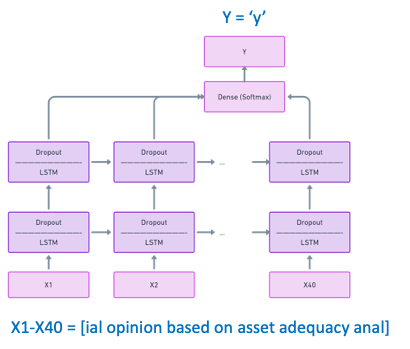

### LSTM (Long Short-Term Memory)
- Tx (sequence length) = 40 
- n_x (input size) = 69 (or len(char))
- n_a (hidden unit size) = 512 (for each LSTM layer)
- Number of parameters = 4 * ((n_x + n_a) * n_a + n_a)
    - 4 is multiplied due to three gates and one tanh in the LSTM structure
### Dense layer
- n_x (input size) = 512 
- n_y (output size) = 69
- Number of parameters = n_x * n_y + n_y 

## 4.2 Model Build

In [8]:
""" Uncomment if a model will be trained from scratch
## Commented out as we will be loading the model from the pre-trained version

print("Building the model...")

# Create a Sequential model
model = Sequential()

# Add an LSTM layer with 512 units and input shape of (Tx, len(chars))
model.add(LSTM(512, input_shape=(Tx, len(chars)), return_sequences=True))

# Add a dropout layer with a rate of 0.5
model.add(Dropout(0.5))

# Add another LSTM layer with 512 units
model.add(LSTM(512))

# Add another dropout layer with a rate of 0.5
model.add(Dropout(0.5))

# Add a Dense layer with a number of units equal to the number of unique characters (len(chars))
# and use the softmax activation function
model.add(Dense(len(chars), activation='softmax'))

# Compile the model with the categorical cross-entropy loss function and the Adam optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam')
"""


' Uncomment if a model will be trained from scratch\n## Commented out as we will be loading the model from the pre-trained version\n\nprint("Building the model...")\n\n# Create a Sequential model\nmodel = Sequential()\n\n# Add an LSTM layer with 512 units and input shape of (Tx, len(chars))\nmodel.add(LSTM(512, input_shape=(Tx, len(chars)), return_sequences=True))\n\n# Add a dropout layer with a rate of 0.5\nmodel.add(Dropout(0.5))\n\n# Add another LSTM layer with 512 units\nmodel.add(LSTM(512))\n\n# Add another dropout layer with a rate of 0.5\nmodel.add(Dropout(0.5))\n\n# Add a Dense layer with a number of units equal to the number of unique characters (len(chars))\n# and use the softmax activation function\nmodel.add(Dense(len(chars), activation=\'softmax\'))\n\n# Compile the model with the categorical cross-entropy loss function and the Adam optimizer\nmodel.compile(loss=\'categorical_crossentropy\', optimizer=\'adam\')\n'

In [9]:
'''Uncomment if a model will be trained from scratch
## Commented out as we will be loading the model from the pre-trained version

# Define a lambda function to be called at the end of each epoch
on_epoch_end = lambda epoch, logs: print(f'Epoch {epoch} finished.')

# Create a LambdaCallback to execute the on_epoch_end function
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

# Create a TensorBoard callback to log training progress
tensorboard_callback = TensorBoard(log_dir='./logs')

# Fit the model to the data
# Change the number of epochs once a model test train is performed
model.fit(x, y, batch_size=128, epochs=1, callbacks=[print_callback, tensorboard_callback])
'''

"Uncomment if a model will be trained from scratch\n## Commented out as we will be loading the model from the pre-trained version\n\n# Define a lambda function to be called at the end of each epoch\non_epoch_end = lambda epoch, logs: print(f'Epoch {epoch} finished.')\n\n# Create a LambdaCallback to execute the on_epoch_end function\nprint_callback = LambdaCallback(on_epoch_end=on_epoch_end)\n\n# Create a TensorBoard callback to log training progress\ntensorboard_callback = TensorBoard(log_dir='./logs')\n\n# Fit the model to the data\n# Change the number of epochs once a model test train is performed\nmodel.fit(x, y, batch_size=128, epochs=1, callbacks=[print_callback, tensorboard_callback])\n"

To read the log from the tensorboard_callback, you can follow these steps:

1. Open a terminal or command prompt and navigate to the directory where your TensorBoard logs are stored (in this case, it is './logs').
2. Run the following command to start TensorBoard: `tensorboard --logdir ./logs`
3. Go to http://localhost:6006/
4. Once TensorBoard starts, you can view the logs by clicking on "Events" in the left sidebar and then selecting "Scalar". This will display a graph of your training metrics over time. You can also explore other tabs like "Images", "Audio", etc., to see different types of visualizations for your model's performance during training.
5. To export the logs as a CSV file, click on the three-dot menu in the top right corner and select "Export Data". Choose "CSV" as the format and save it to a desired location. You can then open this CSV file using any spreadsheet software like Microsoft Excel or Google Sheets for further analysis.

In [10]:
# Save the model once built
## Commented out as we will be loading the model from the pre-trained version
#model.summary()
#model.save('../model/Life_ASOP_rnn_model001.keras')  #rename as needed

## 4.3 Pre-trained Model Load

In [11]:
## Skip this section if a model is built in the prior section
# Load the model
model = load_model('../model/Life_ASOP_rnn_model021.keras')

In [12]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 40, 512)           1191936   
                                                                 
 dropout_8 (Dropout)         (None, 40, 512)           0         
                                                                 
 lstm_9 (LSTM)               (None, 512)               2099200   
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 69)                35397     
                                                                 
Total params: 3326533 (12.69 MB)
Trainable params: 3326533 (12.69 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# 5. Output
## 5.1 Define Functions

In [13]:
def sample(preds, temperature=1.0):
    """
    Helper function to sample an index from a probability array.

    Arguments:
    preds (list): The input probability array.
    temperature (float): Controls the randomness of the sampling. Higher values make the sampling more random.

    Returns:
    int: The sampled index.
    """
    
    preds = np.asarray(preds).astype('float64')

    # Apply logarithm to the probability array (temperature being zero will get an error)
    preds = np.log(preds) / max(temperature, 0.000001)
    exp_preds = np.exp(preds)

    # Apply softmax to normalize the array
    preds = exp_preds / np.sum(exp_preds) 

    # Use the softmax probabilities to perform multinomial sampling
    probas = np.random.multinomial(1, preds, 1)

    # Get the sampled index using the probabilities
    out = np.random.choice(range(len(chars)), p = probas.ravel())
    return out


In [14]:
def generate_output(temperature = 1.0, ASOP_length = 500):
    """
    Generates an ASOP based on user input.
    
    Arguments:
    - temperature (float): Controls the randomness of the generated output. Higher values result in more randomness.
    - ASOP_length (int): The desired length of the generated ASOP in characters.
    
    Returns:
    - generated (str): The generated ASOP string.
    """
    
    generated = '' # Initializes an empty string

    usr_input = input("Write the beginning of your ASOP, the ASOP language model will complete it. Your input is: ")
    
    sentence = ('{0:0>' + str(Tx) + '}').format(usr_input).lower() # Zero pad the input sentence to make length Tx
    generated += usr_input 

    sys.stdout.write("\n\nHere is your ASOP: \n\n") 
    sys.stdout.write(usr_input)
    for i in range(ASOP_length):

        x_pred = np.zeros((1, Tx, len(chars))) # Initialize NumPy array with zeros. len(chars) = 69

        for t, char in enumerate(sentence): # Iterates over each character in the current sentence
            if char != '0':
                x_pred[0, t, char_indices[char]] = 1. # One-hot coding the sentence

        preds = model.predict(x_pred, verbose=0)[0] # Get next character's probability distribution (softmax)
        next_index = sample(preds, temperature = temperature) # Sample an index from the distribution out of len(chars)
        next_char = indices_char[next_index] # Convert index to character

        generated += next_char 
        
        # Updates the sentence by removing its first character 
        # and appending the newly generated character, maintaining a fixed length of Tx.        
        sentence = sentence[1:] + next_char 

        sys.stdout.write(next_char)
        sys.stdout.flush()

        if next_char == '\n':
            continue

## 5.2 Generate ASOP

In [16]:
# Let's generate ASOP!
generate_output(temperature = 0.5, ASOP_length = 500)

Write the beginning of your ASOP, the ASOP language model will complete it. Your input is:  Actuary




Here is your ASOP: 

Actuary 11, 2020. the 
asb adopted asop no. 11, section 4.2, if any 
asop no. 24  
 
this booklet contains the projections of the assumptions and surplus may be appropriate. 
 
the reviewers agree and made the change. 
section 3.5, statements of actuarial opinion 
comment  
 
 
response one commentator suggested adding a definition demutualization for a set of insurance company and ceding entity  and the appropriate analysis one form of the contract policy classes  to be included in the assumptions   
